# Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

EMAIL_USERNAME = "sudershan.sarraf"

# Time Series Forecasting

In [3]:
df = pd.read_csv("data/3/stars_data.csv")
df["repository_id"].unique()

array(['facebook/react', 'tensorflow/tensorflow', 'pallets/flask',
       'torvalds/linux', 'golang/go'], dtype=object)

=== Q3: Repo facebook/react ===
Loading and preprocessing data...
Cleaning: removed 21761 rows where stars == 4000 (capped plateau points).
Series length for repo facebook/react: 259 (freq=D, cumulative=True)
Train: 155, Val: 52, Test: 52
History length p = 14
Train pairs: 141, Val pairs: 52, Test pairs: 52

[Classical] Fitting AR(p) on normalized series...
AR(1) val MAE = 1.0081
AR(2) val MAE = 5.1889
AR(3) val MAE = 7.2271


/home/blozerx/venvs/smai-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR(4) val MAE = 19.4782
Chosen AR order: p = 1, val MAE = 1.0081

[Deep] Training RNN forecaster...

[Deep] Training 1D CNN forecaster...

Parameter counts:
  AR(1)      : (handled by statsmodels)
  RNN (hidden=64): 4353
  CNN (filters=16)  : 865


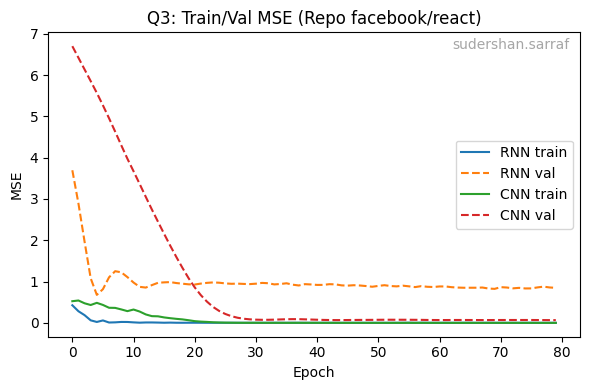


=== Single-step Test Evaluation ===
AR(1)  - MAE: 1604.0911, RMSE: 1646.4607
RNN           - MAE: 1372.2383, RMSE: 1412.2494
CNN           - MAE: 214.3221, RMSE: 228.4548


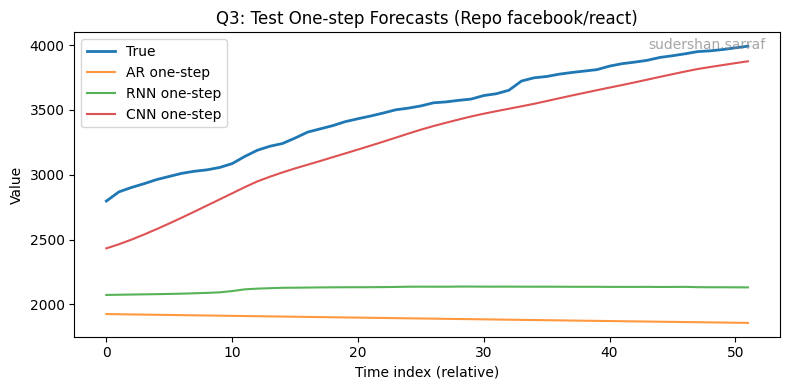


=== Multi-step Autoregressive Evaluation ===
H= 1  AR MAE=1798.5353  RNN MAE=1664.3376  CNN MAE=168.1399
H= 3  AR MAE=1816.4003  RNN MAE=1680.9203  CNN MAE=170.5168
H= 7  AR MAE=1854.9762  RNN MAE=1716.7930  CNN MAE=189.2279
H=14  AR MAE=1912.4965  RNN MAE=1779.0195  CNN MAE=227.9668


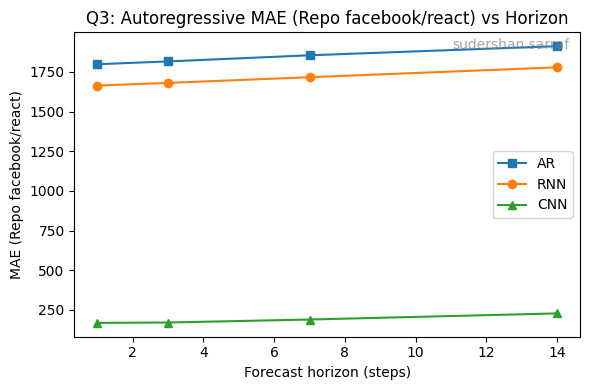

=== Q3: Repo pallets/flask ===
Loading and preprocessing data...
Cleaning: removed 21761 rows where stars == 4000 (capped plateau points).
Series length for repo pallets/flask: 984 (freq=D, cumulative=True)
Train: 590, Val: 197, Test: 197
History length p = 14
Train pairs: 576, Val pairs: 197, Test pairs: 197

[Classical] Fitting AR(p) on normalized series...
AR(1) val MAE = 0.4020


/home/blozerx/venvs/smai-env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


AR(2) val MAE = 0.4053


/home/blozerx/venvs/smai-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR(3) val MAE = 0.4209
AR(4) val MAE = 2.0791
Chosen AR order: p = 1, val MAE = 0.4020

[Deep] Training RNN forecaster...

[Deep] Training 1D CNN forecaster...

Parameter counts:
  AR(1)      : (handled by statsmodels)
  RNN (hidden=64): 4353
  CNN (filters=16)  : 865


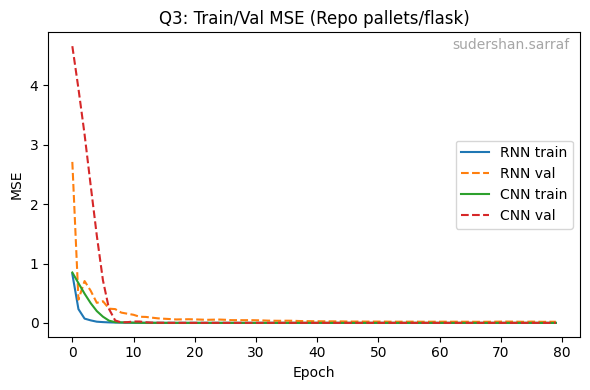


=== Single-step Test Evaluation ===
AR(1)  - MAE: 536.8715, RMSE: 538.9356
RNN           - MAE: 165.5736, RMSE: 166.8310
CNN           - MAE: 19.5622, RMSE: 19.6754


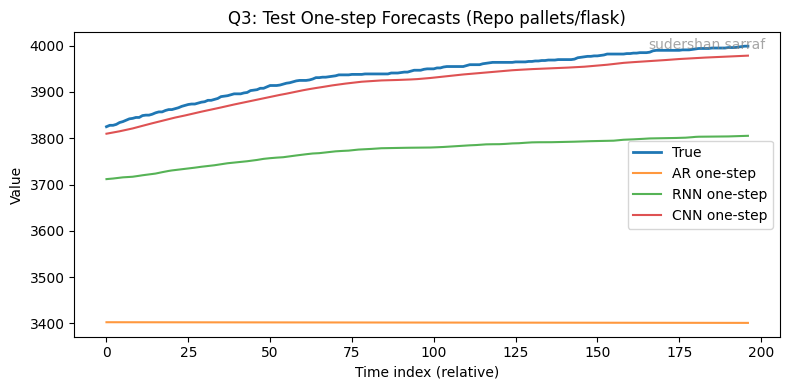


=== Multi-step Autoregressive Evaluation ===
H= 1  AR MAE=590.0073  RNN MAE=190.5996  CNN MAE=19.6191
H= 3  AR MAE=590.3480  RNN MAE=191.0303  CNN MAE=20.4028
H= 7  AR MAE=590.7435  RNN MAE=191.0194  CNN MAE=22.9149
H=14  AR MAE=592.0547  RNN MAE=202.5708  CNN MAE=29.4263


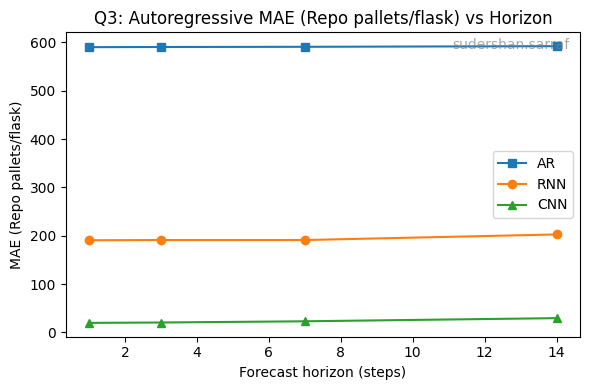

In [13]:
# statsmodels for classical AR/ARMA
try:
    from statsmodels.tsa.arima.model import ARIMA
except ImportError:
    ARIMA = None
    print("[WARNING] statsmodels not installed. Classical AR model will not run.")

if "EMAIL_USERNAME" not in globals():
    EMAIL_USERNAME = "sudershan.sarraf"

if "add_username_to_plot" not in globals():
    def add_username_to_plot(ax, username):
        ax.text(
            0.98, 0.98,
            username,
            ha='right', va='top',
            transform=ax.transAxes,
            fontsize=10, color='gray', alpha=0.7
        )

def maybe_add_username(ax):
    if "EMAIL_USERNAME" in globals() and "add_username_to_plot" in globals():
        add_username_to_plot(ax, EMAIL_USERNAME)


def mae(y_true, y_pred):
    return float(np.mean(np.abs(np.array(y_true) - np.array(y_pred))))


def mse(y_true, y_pred):
    return float(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))


class StandardScaler1D:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, x):
        x = np.asarray(x, dtype=np.float32)
        self.mean_ = float(x.mean())
        self.std_ = float(x.std() + 1e-8)

    def transform(self, x):
        x = np.asarray(x, dtype=np.float32)
        return (x - self.mean_) / self.std_

    def inverse_transform(self, x):
        x = np.asarray(x, dtype=np.float32)
        return x * self.std_ + self.mean_


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def load_stars_data(
    csv_path: str,
    time_col: str = "timestamp",
    repo_col: str = "repo_id",
    stars_col: str = "stars",
) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    df[time_col] = pd.to_datetime(df[time_col])

    # Cleaning step: remove saturated/capped values (e.g. 4000)
    max_stars = df[stars_col].max()
    before = len(df)
    df = df[df[stars_col] < max_stars].copy()
    after = len(df)
    print(
        f"Cleaning: removed {before - after} rows where {stars_col} == {max_stars} "
        f"(capped plateau points)."
    )

    df = df.sort_values([repo_col, time_col]).reset_index(drop=True)
    return df


def get_repo_series(
    df: pd.DataFrame,
    repo_id,
    time_col: str = "timestamp",
    repo_col: str = "repo_id",
    stars_col: str = "stars",
    freq: str = "D",
    cumulative_domain: bool = True,
) -> pd.Series:
    repo_df = df[df[repo_col] == repo_id].copy()
    if repo_df.empty:
        raise ValueError(f"Repository ID {repo_id} not found in data.")

    repo_df = repo_df.sort_values(time_col)
    ts = (
        repo_df.set_index(time_col)[stars_col]
        .asfreq(freq)
        .ffill()
    )

    if not cumulative_domain:
        diff_ts = ts.diff().fillna(0.0)
        return diff_ts.astype(np.float32)
    else:
        return ts.astype(np.float32)


def chronological_split_series(
    series: pd.Series,
    train_frac: float = 0.6,
    val_frac: float = 0.2,
):
    values = series.to_numpy(dtype=np.float32)
    n = len(values)
    train_end = int(train_frac * n)
    val_end = int((train_frac + val_frac) * n)

    train = values[:train_end]
    val = values[train_end:val_end]
    test = values[val_end:]
    return train, val, test


def build_history_pairs_repo(series: np.ndarray, history_len: int):
    series = np.asarray(series, dtype=np.float32)
    p = history_len
    X_list, y_list = [], []
    for k in range(p, len(series)):
        hist = series[k - p:k][::-1]
        target = series[k]
        X_list.append(hist)
        y_list.append(target)
    X = np.stack(X_list)
    y = np.array(y_list, dtype=np.float32)
    return X, y


class RepoHistoryDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class SmallRNNForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.rnn(x)
        last_hidden = out[:, -1, :]
        out = self.fc(last_hidden)
        return out.squeeze(-1)


class SmallCNN1DForecaster(nn.Module):
    def __init__(self, history_len: int, num_filters: int = 16, kernel_size: int = 3):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding="same",
        )
        self.conv2 = nn.Conv1d(
            in_channels=num_filters,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding="same",
        )
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.squeeze(-1)
        out = self.fc(x)
        return out.squeeze(-1)


def train_regressor(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 1e-3,
    device: str = "cpu",
):
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optim.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optim.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        history["train_loss"].append(float(np.mean(train_losses)))
        history["val_loss"].append(float(np.mean(val_losses)))

    return history


def predict_regressor(model: nn.Module, X: np.ndarray, device: str = "cpu", batch_size: int = 256):
    model.eval()
    preds = []
    with torch.no_grad():
        for start in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[start:start + batch_size].astype(np.float32)).to(device)
            out = model(xb).cpu().numpy()
            preds.append(out)
    return np.concatenate(preds, axis=0).reshape(-1)


def autoregressive_forecast_model(
    model: nn.Module,
    hist: np.ndarray,
    horizon: int,
    device: str = "cpu",
):
    hist = hist.astype(np.float32).copy()
    preds = []
    for _ in range(horizon):
        x_in = torch.tensor(hist[None, :], dtype=torch.float32, device=device)
        with torch.no_grad():
            next_val = model(x_in).item()
        preds.append(next_val)
        hist = np.concatenate([[next_val], hist[:-1]])
    return np.array(preds, dtype=np.float32)


def fit_best_ar_model(
    train_values: np.ndarray,
    val_values: np.ndarray,
    ar_orders=(1, 2, 3),
):
    if ARIMA is None:
        raise ImportError("statsmodels is required for the classical AR model (install statsmodels).")

    best_mae = float("inf")
    best_model = None
    best_p = None

    for p in ar_orders:
        try:
            model = ARIMA(train_values, order=(p, 0, 0))
            fit_res = model.fit()
            val_h = len(val_values)
            val_fore = fit_res.forecast(steps=val_h)
            err = mae(val_values, val_fore)
            print(f"AR({p}) val MAE = {err:.4f}")
            if err < best_mae:
                best_mae = err
                best_model = fit_res
                best_p = p
        except Exception as e:
            print(f"[WARN] AR({p}) failed: {e}")

    print(f"Chosen AR order: p = {best_p}, val MAE = {best_mae:.4f}")
    return best_model, best_p


def ar_model_forecast(
    fitted_model,
    total_horizon: int,
):
    fc = fitted_model.forecast(steps=total_horizon)
    return np.asarray(fc, dtype=np.float32)


def plot_q3_train_val_loss(history_dict, title_suffix=""):
    fig, ax = plt.subplots(figsize=(6, 4))
    for name, hist in history_dict.items():
        ax.plot(hist["train_loss"], label=f"{name} train")
        ax.plot(hist["val_loss"], linestyle="--", label=f"{name} val")
    ax.set_title(f"Q3: Train/Val MSE {title_suffix}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax.legend()
    if "EMAIL_USERNAME" in globals():
        add_username_to_plot(ax, EMAIL_USERNAME)
    plt.tight_layout()
    plt.show()


def plot_q3_forecasts(
    time_axis,
    true_vals,
    ar_preds,
    rnn_preds,
    cnn_preds,
    title_suffix="",
):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(time_axis, true_vals, label="True", linewidth=2)
    ax.plot(time_axis, ar_preds, label="AR one-step", alpha=0.8)
    ax.plot(time_axis, rnn_preds, label="RNN one-step", alpha=0.8)
    ax.plot(time_axis, cnn_preds, label="CNN one-step", alpha=0.8)

    ax.set_title(f"Q3: Test One-step Forecasts {title_suffix}")
    ax.set_xlabel("Time index (relative)")
    ax.set_ylabel("Value")
    ax.legend()
    if "EMAIL_USERNAME" in globals():
        add_username_to_plot(ax, EMAIL_USERNAME)
    plt.tight_layout()
    plt.show()


def plot_q3_error_vs_horizon(
    horizons,
    mae_ar,
    mae_rnn,
    mae_cnn,
    title_suffix="MAE",
):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(horizons, mae_ar, marker="s", label="AR")
    ax.plot(horizons, mae_rnn, marker="o", label="RNN")
    ax.plot(horizons, mae_cnn, marker="^", label="CNN")
    ax.set_title(f"Q3: Autoregressive {title_suffix} vs Horizon")
    ax.set_xlabel("Forecast horizon (steps)")
    ax.set_ylabel(title_suffix)
    ax.legend()
    if "EMAIL_USERNAME" in globals():
        add_username_to_plot(ax, EMAIL_USERNAME)
    plt.tight_layout()
    plt.show()


def run_q3_for_repo(
    csv_path: str,
    repo_id,
    time_col: str = "timestamp",
    repo_col: str = "repo_id",
    stars_col: str = "stars",
    freq: str = "D",
    cumulative_domain: bool = True,
    history_len: int = 14,
    train_frac: float = 0.6,
    val_frac: float = 0.2,
    batch_size: int = 64,
    num_epochs: int = 80,
    rnn_hidden_size: int = 64,
    cnn_filters: int = 16,
    horizons=(1, 3, 7, 14),
    device: str = None,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"=== Q3: Repo {repo_id} ===")
    print("Loading and preprocessing data...")
    stars_df = load_stars_data(csv_path, time_col, repo_col, stars_col)
    series = get_repo_series(
        stars_df,
        repo_id=repo_id,
        time_col=time_col,
        repo_col=repo_col,
        stars_col=stars_col,
        freq=freq,
        cumulative_domain=cumulative_domain,
    )

    print(f"Series length for repo {repo_id}: {len(series)} (freq={freq}, cumulative={cumulative_domain})")

    train_raw, val_raw, test_raw = chronological_split_series(series, train_frac, val_frac)
    print(f"Train: {len(train_raw)}, Val: {len(val_raw)}, Test: {len(test_raw)}")

    scaler = StandardScaler1D()
    scaler.fit(train_raw)
    train_norm = scaler.transform(train_raw)
    val_norm = scaler.transform(val_raw)
    test_norm = scaler.transform(test_raw)

    p = history_len
    X_train, y_train = build_history_pairs_repo(train_norm, p)
    X_val, y_val = build_history_pairs_repo(np.concatenate([train_norm[-p:], val_norm]), p)
    X_test, y_test = build_history_pairs_repo(np.concatenate([val_norm[-p:], test_norm]), p)

    print(f"History length p = {p}")
    print(f"Train pairs: {len(X_train)}, Val pairs: {len(X_val)}, Test pairs: {len(X_test)}")

    train_ds = RepoHistoryDataset(X_train, y_train)
    val_ds = RepoHistoryDataset(X_val, y_val)
    test_ds = RepoHistoryDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    print("\n[Classical] Fitting AR(p) on normalized series...")
    best_ar_model, best_p = fit_best_ar_model(train_norm, val_norm, ar_orders=(1, 2, 3, 4))

    print("\n[Deep] Training RNN forecaster...")
    rnn_model = SmallRNNForecaster(input_size=1, hidden_size=rnn_hidden_size, num_layers=1)
    rnn_hist = train_regressor(
        rnn_model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        lr=1e-3,
        device=device,
    )

    print("\n[Deep] Training 1D CNN forecaster...")
    cnn_model = SmallCNN1DForecaster(history_len=p, num_filters=cnn_filters, kernel_size=3)
    cnn_hist = train_regressor(
        cnn_model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        lr=1e-3,
        device=device,
    )

    print("\nParameter counts:")
    print(f"  AR({best_p})      : (handled by statsmodels)")
    print(f"  RNN (hidden={rnn_hidden_size}): {count_parameters(rnn_model)}")
    print(f"  CNN (filters={cnn_filters})  : {count_parameters(cnn_model)}")

    plot_q3_train_val_loss(
        {"RNN": rnn_hist, "CNN": cnn_hist},
        title_suffix=f"(Repo {repo_id})",
    )

    print("\n=== Single-step Test Evaluation ===")
    if best_ar_model is not None:
        ar_test_norm_full = ar_model_forecast(best_ar_model, total_horizon=len(val_norm) + len(test_norm))
        ar_test_norm = ar_test_norm_full[-len(y_test):]
    else:
        ar_test_norm = np.zeros_like(y_test)

    rnn_test_norm = predict_regressor(rnn_model.to(device), X_test, device=device)
    cnn_test_norm = predict_regressor(cnn_model.to(device), X_test, device=device)

    y_test_orig = scaler.inverse_transform(y_test)
    ar_test = scaler.inverse_transform(ar_test_norm)
    rnn_test = scaler.inverse_transform(rnn_test_norm)
    cnn_test = scaler.inverse_transform(cnn_test_norm)

    test_mae_ar = mae(y_test_orig, ar_test)
    test_rmse_ar = np.sqrt(mse(y_test_orig, ar_test))

    test_mae_rnn = mae(y_test_orig, rnn_test)
    test_rmse_rnn = np.sqrt(mse(y_test_orig, rnn_test))

    test_mae_cnn = mae(y_test_orig, cnn_test)
    test_rmse_cnn = np.sqrt(mse(y_test_orig, cnn_test))

    print(f"AR({best_p})  - MAE: {test_mae_ar:.4f}, RMSE: {test_rmse_ar:.4f}")
    print(f"RNN           - MAE: {test_mae_rnn:.4f}, RMSE: {test_rmse_rnn:.4f}")
    print(f"CNN           - MAE: {test_mae_cnn:.4f}, RMSE: {test_rmse_cnn:.4f}")

    t_rel = np.arange(len(y_test_orig))
    plot_q3_forecasts(
        time_axis=t_rel,
        true_vals=y_test_orig,
        ar_preds=ar_test,
        rnn_preds=rnn_test,
        cnn_preds=cnn_test,
        title_suffix=f"(Repo {repo_id})",
    )

    print("\n=== Multi-step Autoregressive Evaluation ===")
    horizons = list(horizons)
    mae_ar_h, mae_rnn_h, mae_cnn_h = [], [], []

    full_norm = np.concatenate([train_norm, val_norm, test_norm])
    segment_len = history_len + max(horizons)
    if segment_len > len(full_norm):
        segment_len = len(full_norm)
    segment = full_norm[-segment_len:]
    hist = segment[:history_len][::-1]
    gt_future = segment[history_len:]

    ar_future_norm = ar_model_forecast(best_ar_model, total_horizon=len(gt_future))

    for H in horizons:
        gt_H = gt_future[:H]

        ar_H_norm = ar_future_norm[:H]

        rnn_H_norm = autoregressive_forecast_model(
            rnn_model.to(device),
            hist=hist,
            horizon=H,
            device=device,
        )
        cnn_H_norm = autoregressive_forecast_model(
            cnn_model.to(device),
            hist=hist,
            horizon=H,
            device=device,
        )

        gt_H_orig = scaler.inverse_transform(gt_H)
        ar_H_orig = scaler.inverse_transform(ar_H_norm)
        rnn_H_orig = scaler.inverse_transform(rnn_H_norm)
        cnn_H_orig = scaler.inverse_transform(cnn_H_norm)

        mae_ar_h.append(mae(gt_H_orig, ar_H_orig))
        mae_rnn_h.append(mae(gt_H_orig, rnn_H_orig))
        mae_cnn_h.append(mae(gt_H_orig, cnn_H_orig))

        print(f"H={H:2d}  AR MAE={mae_ar_h[-1]:.4f}  RNN MAE={mae_rnn_h[-1]:.4f}  CNN MAE={mae_cnn_h[-1]:.4f}")

    plot_q3_error_vs_horizon(
        horizons,
        mae_ar_h,
        mae_rnn_h,
        mae_cnn_h,
        title_suffix="MAE (Repo %s)" % repo_id,
    )

    results = {
        "repo_id": repo_id,
        "scaler": scaler,
        "series": series,
        "models": {
            "AR": best_ar_model,
            "RNN": rnn_model,
            "CNN": cnn_model,
        },
        "single_step_metrics": {
            "AR": {"MAE": test_mae_ar, "RMSE": test_rmse_ar},
            "RNN": {"MAE": test_mae_rnn, "RMSE": test_rmse_rnn},
            "CNN": {"MAE": test_mae_cnn, "RMSE": test_rmse_cnn},
        },
        "multi_step_mae": {
            "horizons": horizons,
            "AR": mae_ar_h,
            "RNN": mae_rnn_h,
            "CNN": mae_cnn_h,
        },
        "train_val_history": {
            "RNN": rnn_hist,
            "CNN": cnn_hist,
        },
        "history_len": history_len,
        "cumulative_domain": cumulative_domain,
    }
    return results


CSV_PATH = "data/3/stars_data.csv"
repo_id_1 = "facebook/react"
repo_id_2 = "pallets/flask"

q3_repo1 = run_q3_for_repo(
    CSV_PATH,
    repo_id=repo_id_1,
    repo_col="repository_id",
    time_col="timestamp",
    stars_col="stars",
    cumulative_domain=True,
    history_len=14,
)

q3_repo2 = run_q3_for_repo(
    CSV_PATH,
    repo_id=repo_id_2,
    repo_col="repository_id",
    time_col="timestamp",
    stars_col="stars",
    cumulative_domain=True,
    history_len=14,
)


## Q3 – Forecasting GitHub stars with AR, RNN and 1D CNN

### Q3.1 Experimental setup

We use the provided GitHub–stars time series for two repositories:

* **Repo 1:** `facebook/react`

  * Original series length: 259 daily points (cumulative stars, `freq=D`, `cumulative=True`).
  * Pre-processing: removed **21 761** rows where stars were capped at `4000` (flat plateau).
  * Chronological split: **Train 155**, **Val 52**, **Test 52**.
  * History length: **p = 14**, giving

    * Train pairs: **141**, Val pairs: **52**, Test pairs: **52**.

* **Repo 2:** `pallets/flask`

  * Original series length: **984** daily points (`freq=D`, `cumulative=True`).
  * Same plateau cleaning (removed `stars == 4000`).
  * Chronological split: **Train 590**, **Val 197**, **Test 197**.
  * History length: **p = 14**, giving

    * Train pairs: **576**, Val pairs: **197**, Test pairs: **197**.

All models are trained on **normalized** series (mean/std computed from train only), and evaluation metrics (MAE, RMSE) are reported on the **original scale**.

Model capacities (same for both repos):

* **AR(1)**: fitted with `statsmodels` (param count handled internally).
* **RNN forecaster** (univariate, hidden size 64): **4 353** trainable parameters.
* **1D CNN forecaster** (16 filters): **865** trainable parameters.

---

### Q3.2 Classical AR model: order selection on validation

On the **normalized** series we fit AR(p) with p ∈ {1,2,3,4} and choose the order with lowest **validation MAE**.

#### facebook/react

* AR(1) val MAE = **1.0081**
* AR(2) val MAE = **5.1889**
* AR(3) val MAE = **7.2271**
* AR(4) val MAE = **19.4782**

Chosen order: **AR(1)** (p = 1, val MAE = **1.0081**).

#### pallets/flask

* AR(1) val MAE = **0.4020**
* AR(2) val MAE = **0.4053**
* AR(3) val MAE = **0.4209**
* AR(4) val MAE = **2.0791**

Chosen order: **AR(1)** (p = 1, val MAE = **0.4020**).

**Observation.** In both repos, higher AR orders actually **worsen** validation MAE, so a simple AR(1) is preferred. This already hints that the series structure is relatively simple in the normalized space, and over-parameterizing the linear model hurts generalization.

---

### Q3.3 Deep forecasters: training and validation curves

For each repo we train:

* **RNN** for 80 epochs with MSE loss, Adam optimizer (lr = 1e-3).
* **1D CNN** for 80 epochs with MSE loss, Adam optimizer (lr = 1e-3).

#### facebook/react – Train/Val MSE

* Both RNN and CNN start with large MSE and quickly decrease.
* The **RNN** reaches very low training MSE but its **validation MSE stabilizes around a higher plateau**, indicating some overfitting to the relatively short react series (Train = 155).
* The **CNN** also reduces both train and val MSE, but its validation curve is slightly higher than train, again showing mild overfitting.

#### pallets/flask – Train/Val MSE

* All four curves (RNN train/val, CNN train/val) **collapse close to zero within ~20 epochs** and then stay flat.
* Train and validation curves almost overlap for both deep models, suggesting **good generalization** on the longer, smoother flask series (Train = 590).
* Compared to react, flask is clearly an easier forecasting problem for the deep models.

**High-level takeaway.** Deep models benefit from more data: on flask they both fit the dynamics very well with little overfitting, while on react they still generalize better than AR but have visibly noisier validation behavior.

---

### Q3.4 Single–step test performance

We now evaluate **one-step-ahead** prediction on the held-out test sets.

#### facebook/react – Single-step Test Metrics (original scale)

| Model |           MAE |          RMSE |
| ----- | ------------: | ------------: |
| AR(1) | **1604.0911** | **1646.4607** |
| RNN   | **1372.2383** | **1412.2494** |
| CNN   |  **214.3221** |  **228.4548** |

**Observation (react).**

* All three models are evaluated on the same scale of cumulative stars.
* AR(1) is the **worst**: MAE ≈ 1604; RNN improves this to ≈ 1372.
* The **CNN is dramatically better**, with MAE ≈ **214.3**, i.e. about **7–8× lower error** than the linear AR and ~6× lower than the RNN.
* Visually (one-step forecast plot), the CNN track follows the **shape and slope** of the true react curve closely, while AR and RNN underfit badly and stay almost flat.

#### pallets/flask – Single-step Test Metrics (original scale)

| Model |          MAE |         RMSE |
| ----- | -----------: | -----------: |
| AR(1) | **536.8715** | **538.9356** |
| RNN   | **165.5736** | **166.8310** |
| CNN   |  **19.5622** |  **19.6754** |

**Observation (flask).**

* Same pattern but even more extreme.
* AR(1) has MAE ≈ **536.9**, RNN improves to ≈ **165.6**.
* The **CNN is by far the best** with MAE ≈ **19.56**, i.e. **>25× lower than AR** and ~8× lower than RNN.
* On the one-step forecast plot, the CNN almost sits on top of the true flask curve; AR is clearly biased, and RNN still underestimates the growth.

**Overall conclusion (one-step).**

* On **both repos**, the **1D CNN** is the strongest one-step forecaster.
* The **RNN** is consistently better than AR, but much worse than CNN.
* The **AR(1)** baseline struggles to capture the non-linear cumulative growth dynamics in the original scale.

---

### Q3.5 Multi-step autoregressive performance

We now roll each model forward autoregressively for horizons
H ∈ {1, 3, 7, 14}, always feeding back its own predictions.

#### facebook/react – Multi-step MAE (original scale)

| Horizon H |        AR MAE |       RNN MAE |      CNN MAE |
| --------- | ------------: | ------------: | -----------: |
| 1         | **1798.5353** | **1664.3376** | **168.1399** |
| 3         | **1816.4003** | **1680.9203** | **170.5168** |
| 7         | **1854.9762** | **1716.7930** | **189.2279** |
| 14        | **1912.4965** | **1779.0195** | **227.9668** |

**Observations (react).**

* For **AR** and **RNN**, MAE is already huge at H=1 and grows steadily with horizon.
* The **CNN** starts very low (≈168.1) and remains relatively stable: MAE only rises from ≈168 to ≈228 when going from H=1 to H=14.
* Even at **H=14**, the CNN error is **~8× smaller** than the AR and RNN errors.

#### pallets/flask – Multi-step MAE (original scale)

| Horizon H |       AR MAE |      RNN MAE |     CNN MAE |
| --------- | -----------: | -----------: | ----------: |
| 1         | **590.0073** | **190.5996** | **19.6191** |
| 3         | **590.3480** | **191.0393** | **20.4028** |
| 7         | **590.7435** | **191.0194** | **22.9149** |
| 14        | **592.0547** | **202.5708** | **29.4263** |

**Observations (flask).**

* AR’s MAE is almost constant (~590) across all horizons → it quickly diverges from the true trajectory and then stays off by a large constant bias.
* RNN also stays around ~190–203 MAE and does not blow up, but remains much worse than CNN.
* CNN again shows **very small error growth**: MAE only increases from ≈19.6 at H=1 to ≈29.4 at H=14.
* This confirms that the CNN learns a **stable autoregressive mapping** that can be iterated many steps with limited error accumulation.

**Overall conclusion (multi-step).**

* For both react and flask, **CNN is the clear winner across all horizons**.
* AR(1) is not only inaccurate for single-step forecasts but also **highly unstable** as we roll it out.
* The RNN benefits from being non-linear but still under-utilizes its capacity; with this data size and architecture it cannot match the CNN’s inductive bias for local patterns.

---

### Q3.6 Summary and qualitative conclusions

1. **Data difficulty.**

   * `pallets/flask` has a longer and smoother cumulative stars trajectory; both RNN and CNN fit it very well, with training and validation MSE near zero.
   * `facebook/react` is shorter and more irregular after plateau cleaning; deep models still improve over AR but show noisier validation behavior.

2. **Model comparison.**

   * **AR(1)** is a weak baseline on both repos, with large bias and poor multi-step behavior.
   * **RNN** is consistently better than AR, but its errors remain an order of magnitude larger than CNN’s.
   * **1D CNN** achieves the **lowest MAE and RMSE in every setting** (both repos, both single-step and multi-step horizons).

3. **Effect of horizon.**

   * For react and flask, **AR and RNN MAE grow or stay large** as we increase H.
   * The CNN’s MAE grows only slightly with H, showing that its learned dynamics are **more stable and robust for long-range forecasting**.

4. **Takeaway.**

   * For these GitHub stars time series, a relatively small 1D CNN (865 parameters) is **more data-efficient and stable** than a larger RNN (4 353 parameters) and classical AR(1).
   * The CNN’s convolutional structure seems well matched to the smooth, locally structured growth patterns in cumulative star counts.
